$\textbf{Student:}$ Carlos Daniel Fontes da Silva\
$\textbf{E-mail:}$ carlos.fontes@ee.ufcg.edu.br

# Optical Fibers analysis

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, jvp, kv, kvp
from scipy.constants import c, pi, mu_0, epsilon_0
from scipy.signal import find_peaks, lfilter
from labellines import labelLine, labelLines

## Field components functions

In [36]:
def hybrid(u, v, ρ1, ρ2, Φ, neff, k, m):
    # Constants
    b1 = jvp(m, u) / (u*jv(m, u)) 
    b2 = kvp(m, v) / (v*kv(m, v)) 
    
    F1 = ((u*v)/(np.sqrt(u**2+v**2)))**2 * (b1 + (1-2*Δ)*b2)/v
    F2 = ((np.sqrt(u**2+v**2))/(u*v))**2 * (v/(b1+b2))
    
    a1 = (F2-1)/2
    a2 = (F2+1)/2
    a3 = (F1-1)/2
    a4 = (F1+1)/2
    a5 = (F1-1+2*Δ)/2
    a6 = (F1+1-2*Δ)/2
    
    # Core
    Eρ_core = ( (a1*jv(m-1,u*ρ1/a) + a2*jv(m+1,u*ρ1/a) ) / jv(m, u)  ) * np.cos(m*Φ)
    EΦ_core = ( (a1*jv(m-1,u*ρ1/a) - a2*jv(m+1,u*ρ1/a) ) / jv(m, u) )  * np.sin(m*Φ)
    Ez_core = ( (-1j*u/(a*k*neff)) * jv(m, u*ρ1/a) / jv(m, u) )        * np.cos(m*Φ)
    
    Hρ_core = ( -(np.sqrt(epsilon_0/mu_0)) * (n_co**2/neff) * (a3*jv(m-1,u*ρ1/a) - a4*jv(m+1,u*ρ1/a) ) / jv(m, u) ) * np.sin(m*Φ)
    HΦ_core = ( (np.sqrt(epsilon_0/mu_0)) * (n_co**2/neff) * (a3*jv(m-1,u*ρ1/a) + a4*jv(m+1,u*ρ1/a) ) / jv(m, u) )  * np.cos(m*Φ)
    Hz_core = ( -1j*(np.sqrt(epsilon_0/mu_0)) * (u*F2/(k*ρ1)) * jv(m, u*ρ1/a) / jv(m, u) )                          * np.sin(m*Φ)
    
    # Cladding
    Eρ_cladding = ( (u/v) * (a1*kv(m-1,v*ρ2/a) - a2*kv(m+1,v*ρ2/a) ) / kv(m, v) ) * np.cos(m*Φ)
    EΦ_cladding = ( (u/v) * (a1*kv(m-1,v*ρ2/a) + a2*kv(m+1,v*ρ2/a) ) / kv(m, v) ) * np.sin(m*Φ)
    Ez_cladding = ( (-1j*u/(a*k*neff)) * kv(m, v*ρ2/a) / kv(m, v) )               * np.cos(m*Φ)
    
    Hρ_cladding = ( -(np.sqrt(epsilon_0/mu_0)) * (n_co**2/neff) * (u/v) * (a5*kv(m-1,v*ρ2/a) + a6*kv(m+1,v*ρ2/a) ) / kv(m, v) ) * np.sin(m*Φ)
    HΦ_cladding = ( (np.sqrt(epsilon_0/mu_0)) * (n_co**2/neff) * (u/v) * (a5*kv(m-1,v*ρ2/a) - a6*kv(m+1,v*ρ2/a) ) / kv(m, v) )  * np.cos(m*Φ)
    Hz_cladding = ( -1j*(np.sqrt(epsilon_0/mu_0)) * (u*F2/(k*ρ2)) * kv(m, v*ρ2/a) / kv(m, v) )                                  * np.sin(m*Φ)
    
    # Poynting vector
    Pz_core = np.real(Eρ_core*np.conj(HΦ_core) - EΦ_core*np.conj(Hρ_core))/2
    Pz_cladding = np.real(Eρ_cladding*np.conj(HΦ_cladding) - EΦ_cladding*np.conj(Hρ_cladding))/2
    
    return Pz_core, Pz_cladding, Eρ_core, EΦ_core, Ez_core, Eρ_cladding, EΦ_cladding, Ez_cladding

In [37]:
def TE(u, v, ρ1, ρ2, Φ, neff, k):
    # Core    
    Eρ_core = np.zeros(np.shape(ρ1))
    EΦ_core = jv(1,u*ρ1/a)/jv(1,u)
    Ez_core = np.zeros(np.shape(ρ1))
    
    Hρ_core = -neff*np.sqrt(epsilon_0/mu_0)*jv(1,u*ρ1/a)/jv(1,u)
    HΦ_core = np.zeros(np.shape(ρ1))
    Hz_core = np.sqrt(epsilon_0/mu_0)*(1j/(k*a))*(u*jv(0,u*ρ1/a)/jv(1,u))

    # Cladding
    Eρ_cladding = np.zeros(np.shape(ρ2))
    EΦ_cladding = kv(1,v*ρ2/a)/kv(1,v)
    Ez_cladding = np.zeros(np.shape(ρ2))
    
    Hρ_cladding = -neff*np.sqrt(epsilon_0/mu_0)*kv(1,v*ρ2/a)/kv(1,v)
    HΦ_cladding = np.zeros(np.shape(ρ2))
    Hz_cladding = np.sqrt(epsilon_0/mu_0)*(1j/(k*a))*(-v*kv(0,v*ρ2/a)/kv(1,v))
    
    # Poynting vector
    Pz_core = np.real(Eρ_core*np.conj(HΦ_core) - EΦ_core*np.conj(Hρ_core))/2
    Pz_cladding = np.real(Eρ_cladding*np.conj(HΦ_cladding) - EΦ_cladding*np.conj(Hρ_cladding))/2
    
    return Pz_core, Pz_cladding, Eρ_core, EΦ_core, Ez_core, Eρ_cladding, EΦ_cladding, Ez_cladding

In [38]:
def TM(u, v, ρ1, ρ2, Φ, neff, k):
    # Core    
    Eρ_core = jv(1,u*ρ1/a)/jv(1,u)
    EΦ_core = np.zeros(np.shape(ρ1))
    Ez_core = (1j/(k*neff*a)) * (u*jv(0, u*ρ1/a)/jv(1,u))
    
    Hρ_core = np.zeros(np.shape(ρ1))
    HΦ_core = np.sqrt(epsilon_0/mu_0) * (n_co**2/neff) * jv(1,u*ρ1/a)/jv(1,u)
    Hz_core = np.zeros(np.shape(ρ1))

    # Cladding
    Eρ_cladding = (n_co/n_cl)**2 * kv(1,v*ρ2/a)/kv(1,v)
    EΦ_cladding = np.zeros(np.shape(ρ2))
    Ez_cladding = - (1j/(k*neff*a)) * (n_co/n_cl)**2 * v * kv(0,v*ρ2/a)/kv(1,v)
    
    Hρ_cladding = np.zeros(np.shape(ρ2))
    HΦ_cladding = np.sqrt(epsilon_0/mu_0) * (n_co**2/neff) * kv(1,v*ρ2/a)/kv(1,v)
    Hz_cladding = np.zeros(np.shape(ρ2))
        
    # Poynting vector
    Pz_core = np.real(Eρ_core*np.conj(HΦ_core) - EΦ_core*np.conj(Hρ_core))/2
    Pz_cladding = np.real(Eρ_cladding*np.conj(HΦ_cladding) - EΦ_cladding*np.conj(Hρ_cladding))/2
    
    return Pz_core, Pz_cladding, Eρ_core, EΦ_core, Ez_core, Eρ_cladding, EΦ_cladding, Ez_cladding

In [39]:
def propagation(modes, λ, neff):
    
    p = modes[0]
    m = modes[1]
    n = modes[2]
    
    k = 2*pi/λ
    u = (a*k)*np.sqrt((n_co**2 - neff**2))
    v = (a*k)*np.sqrt((neff**2 - n_cl**2))
    
    Neff = np.nan
    
    if(p == 'HE'):
        A = n_co**2
        B = (kvp(m,v)/kv(m,v))*( n_co**2 + n_cl**2 ) / v
        C =  (n_cl/v)**2 * (kvp(m,v)/kv(m,v))**2 - (neff*m)**2 * (( np.sqrt(u**2+v**2) )/(u*v))**4
        
        LHS = jvp(m,u)/(u*jv(m,u))
        RHS = (-B - np.sqrt(B**2 - 4*A*C)) / (2*A) 
        
        peak, _   = find_peaks( - abs(LHS - RHS), prominence = 0)

        if(len(peak) >= n):
            Neff = np.flip(neff[peak])[n-1]
            
        return Neff
    
    elif(p == 'EH'):
        A = n_co**2
        B = (kvp(m,v)/kv(m,v))*( n_co**2 + n_cl**2 ) / v
        C =  (n_cl/v)**2 * (kvp(m,v)/kv(m,v))**2 - (neff*m)**2 * (( np.sqrt(u**2+v**2) )/(u*v))**4
        
        LHS = jvp(m,u)/(u*jv(m,u))
        RHS = (-B + np.sqrt(B**2 - 4*A*C)) / (2*A) 
        
        peak, _   = find_peaks( - abs(LHS - RHS), prominence = 0) 
        
        if(len(peak) >= n):
            Neff = np.flip(neff[peak])[n-1]
            
        return Neff
    
    elif(p == 'TE'):
        LHS = jv(1,u)/(u*jv(0,u))
        RHS = -kv(1,v)/(v*kv(0,v))
        
        peak, _   = find_peaks( - abs(LHS - RHS), prominence = 0)

        if(len(peak) >= n):
            Neff = np.flip(neff[peak])[n-1]
            
        return Neff
    
    elif(p == 'TM'):
        LHS = n_co**2*jv(1,u)/(u*jv(0,u))
        RHS = -n_cl**2*kv(1,v)/(v*kv(0,v))
        
        peak, _   = find_peaks( - abs(LHS - RHS), prominence = 0)

        if(len(peak) >= n):
            Neff = np.flip(neff[peak])[n-1]
            
        return Neff
    
    else:
        LHS = u*jvp(m,u)/(jv(m,u))
        RHS = v*kvp(m,v)/(kv(m,v))
        
        peak, _   = find_peaks( - abs(LHS - RHS), prominence = 0)

        if(len(peak) >= n):
            Neff = np.flip(neff[peak])[n-1]
            
        return Neff

## 1 - Fiber parameters

In [47]:
a     = 0.3e-6               # Intern radius
n_co  = 2.00                 # Core index
n_cl  = 1.70                 # Cladding index
Δ = (1 - (n_cl/n_co)**2)/2   # Delta index

In [48]:
V_set = 3.7                                # Normalized frequency of operation
V     = np.linspace(0.1, 6.5, 1000)
λ     = 2*pi*a*np.sqrt(n_co**2-n_cl**2)/V

In [49]:
# Returns the array index where V[K] = V_set
K = np.where( abs(V - V_set) < 1e-2 )
K = np.where( min(abs(V[K] - V_set)) == abs(V - V_set) )

In [50]:
ρ = np.linspace(1e-12, 2*a, 400)
Φ = np.linspace(0, 2*pi, 200)

ρ1 = ρ[0 : int(len(ρ)/2)]
ρ2 = ρ[int(len(ρ)/2) : len(ρ)]

rho1, phi1 = np.meshgrid(ρ1, Φ)
rho2, phi2 = np.meshgrid(ρ2, Φ)

## 2 - Universal curve

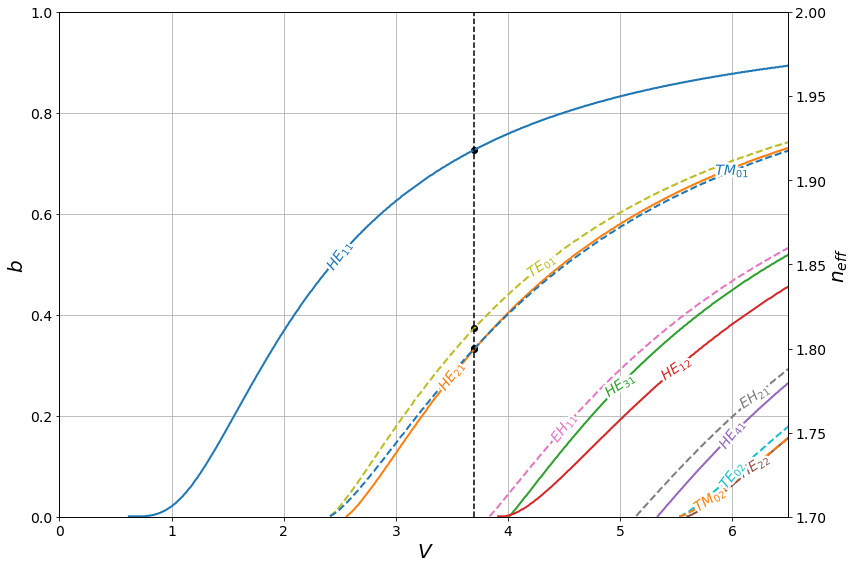

In [51]:
modes = [ ['HE',1,1], ['HE',2,1], ['HE',3,1], ['HE',1,2], ['HE',4,1], ['HE',2,2],
          ['EH',1,1], ['EH',2,1], ['TE',0,1], ['TE',0,2], ['TM',0,1], ['TM',0,2] ]

b = np.zeros(len(V))
neff = np.zeros(len(V))

prop = []
p = 0

fig, ax = plt.subplots(figsize = (12, 8))

for i in range(len(modes)):
    
    for j in range(len(V)):
        neff[j] = propagation(modes[i], λ[j], np.linspace(n_cl*1.0000001, n_co*0.9999999, len(V)))
    
    b = (neff**2 - n_cl**2) / (n_co**2 - n_cl**2)
    
    Vc = V[np.min(np.where(~np.isnan(b)))]

    if(modes[i][0] == 'HE'):
        ax.plot(V, b, lw = 2, label = '$'+ modes[i][0] + '_{' + str(modes[i][1]) + str(modes[i][2]) +'} $'  )
    else:
        ax.plot(V, b,'--', lw = 2, label = '$'+ modes[i][0] + '_{' + str(modes[i][1]) + str(modes[i][2]) +'} $' )
    
    if(~np.isnan(neff[K])):
        prop.append([modes[i][0], modes[i][1], modes[i][2], neff[K][0], Vc])
        ax.scatter(V[K], b[K], color = 'k')
        p += 1
        
labelLines(ax.get_lines(), xvals = [2.5, 3.5, 5, 5.5, 6, 6.2, 4.5, 6.2, 4.3, 6, 6, 5.8], fontsize = 14 )
ax.axvline(V[K], ls = '--', color = 'k')
ax.set_ylim(0, 1)
ax.set_xlim(0, max(V))
ax.set_xlabel(r"V", fontsize = 20, fontstyle = 'italic')
ax.set_ylabel(r"b", fontsize = 20, fontstyle = 'italic')
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.grid()

ax1 = ax.twinx()
ax1.set_ylim(n_cl, n_co)
ax1.set_ylabel(r'$n_{eff}$', fontsize = 20, fontstyle = 'italic')
ax1.tick_params(axis='y', labelsize=14)

plt.tight_layout()

## 3 - Field profiles

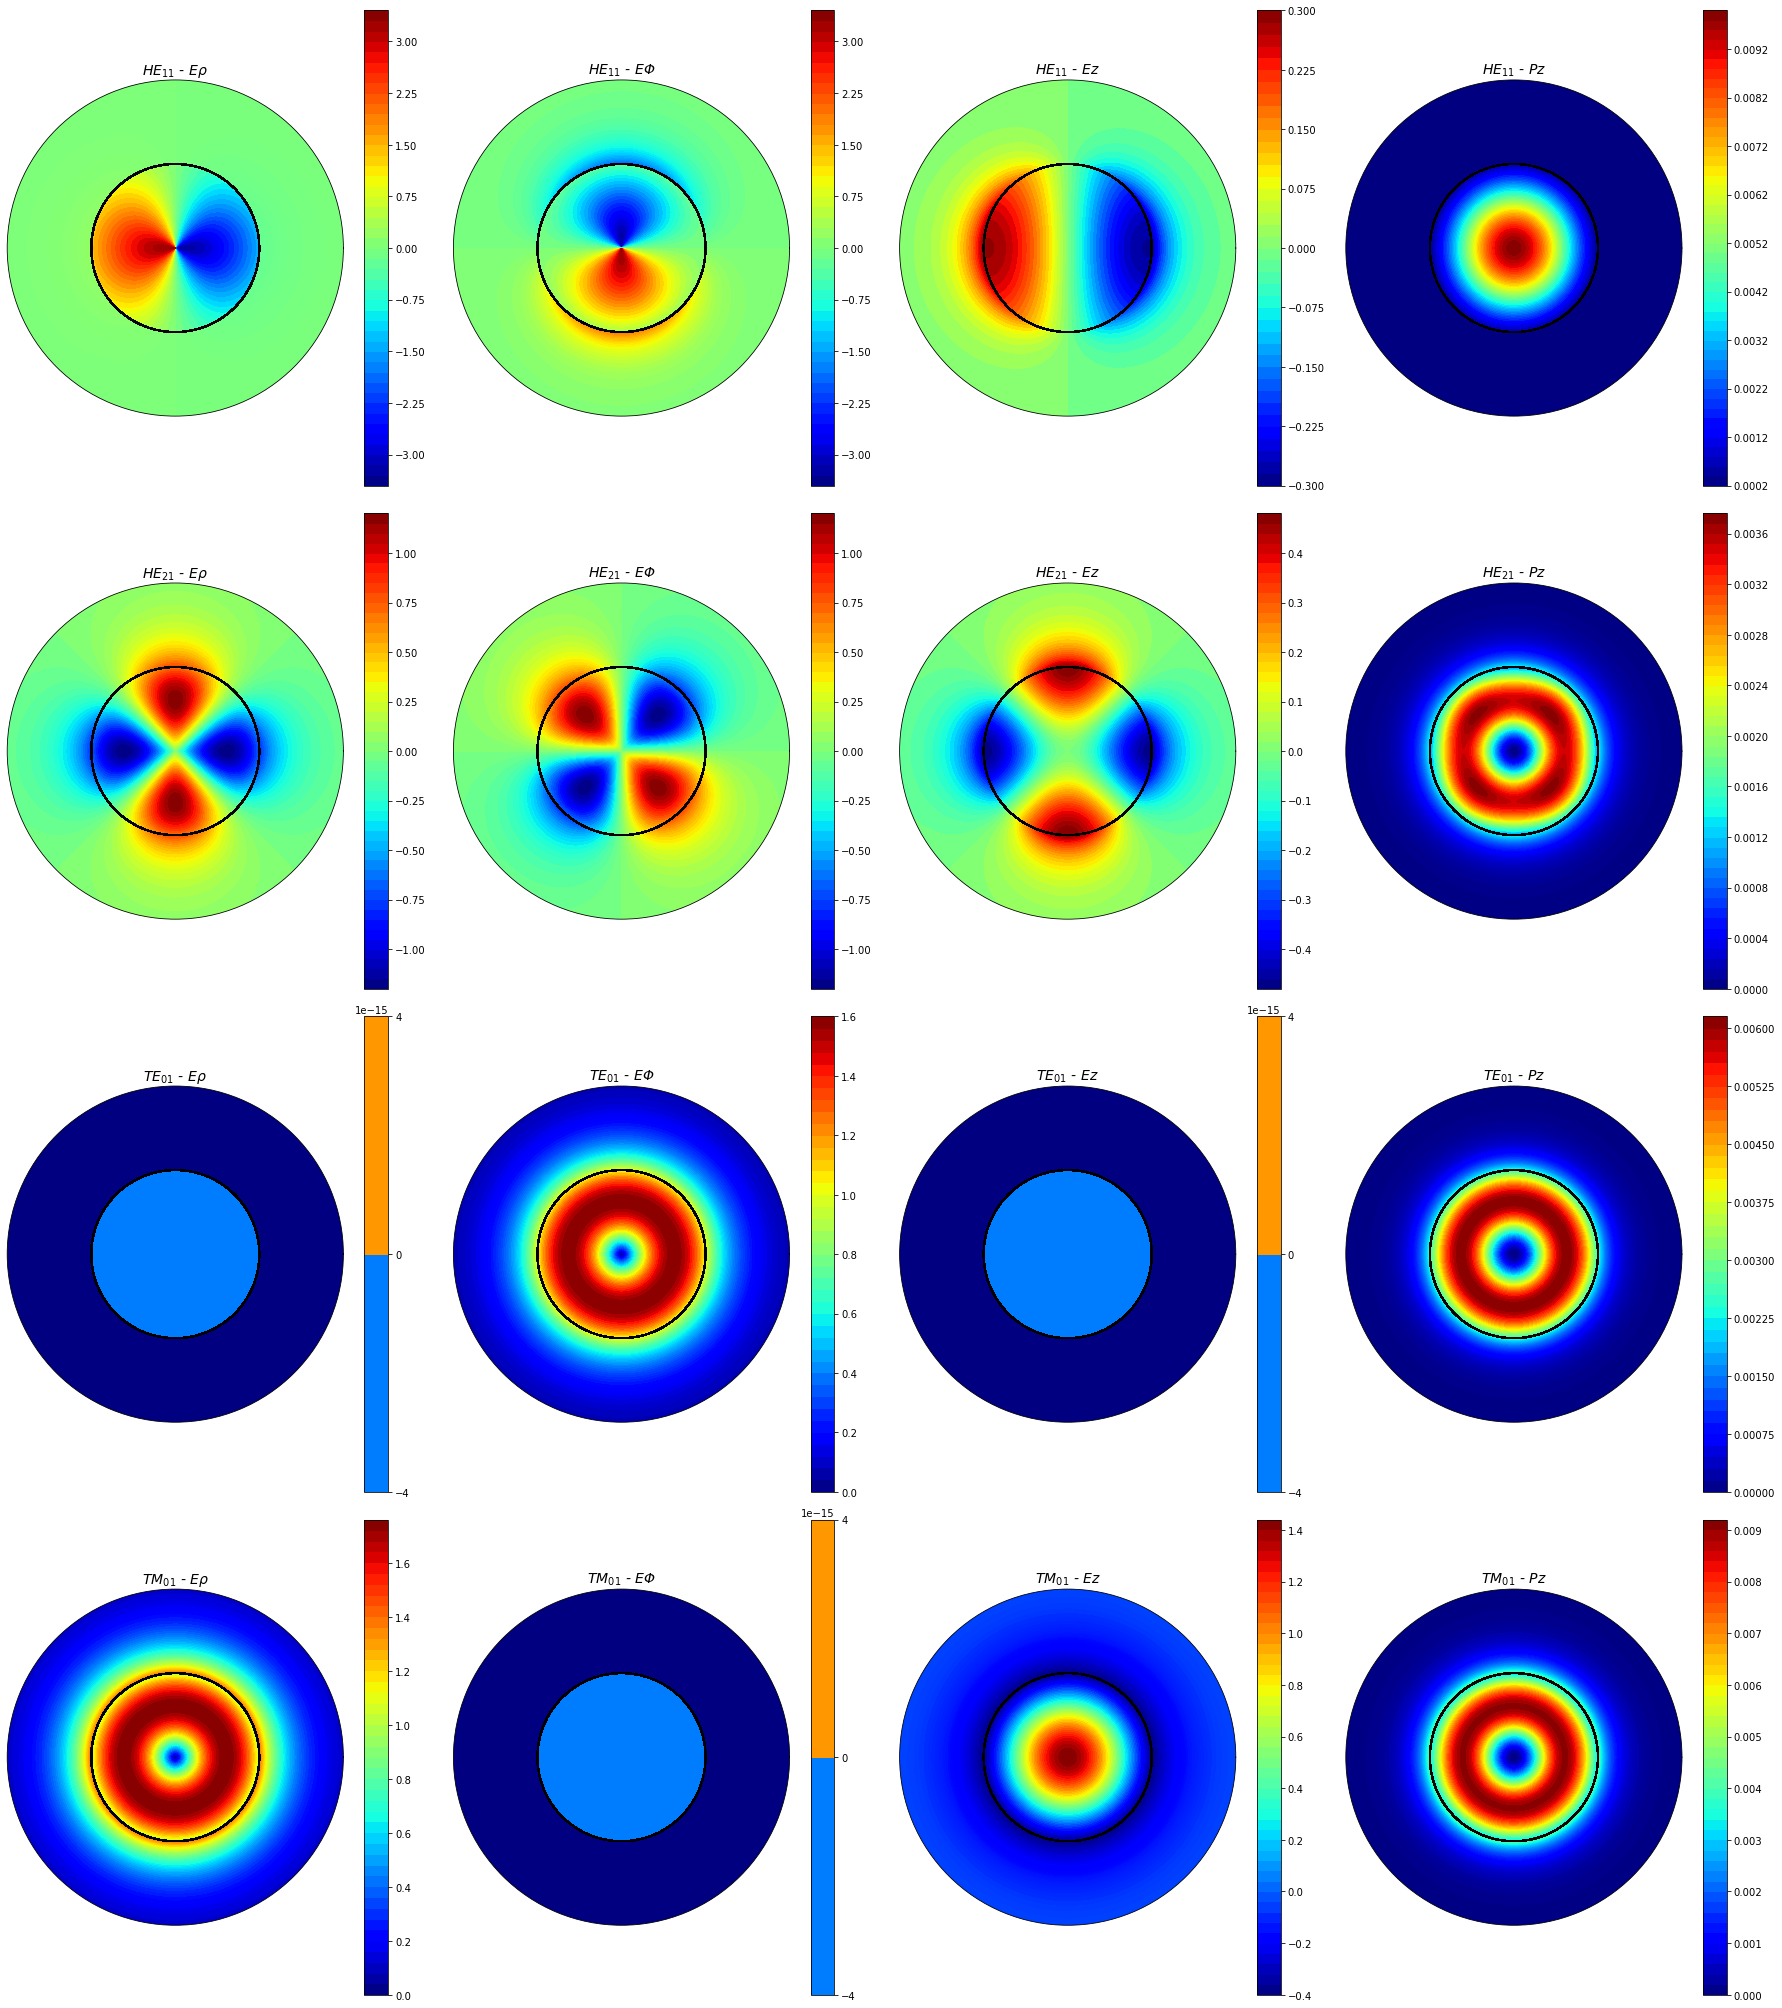

In [53]:
fig, axs = plt.subplots(len(prop), 4, figsize = (25, 7*len(prop)),subplot_kw=dict(projection='polar'), squeeze=False)
mycmap = plt.get_cmap('jet')

title = ['Eρ','EΦ','Ez','Pz']

for i in range(len(prop)):
    p = prop[i][0]
    m = prop[i][1]
    n = prop[i][2]
    neff = prop[i][3]
    
    k = 2*pi/λ[K]
    u = a*k*np.sqrt(n_co**2 - neff**2)
    v = a*k*np.sqrt(neff**2 - n_cl**2)
    
    if(p == 'HE' or p == 'EH'):
        Pz_core, Pz_cladding, Eρ_core, EΦ_core, Ez_core, Eρ_cladding, EΦ_cladding, Ez_cladding = hybrid(u, v, rho1, rho2, phi1, neff, k, m)
        
    elif(p == 'TE'):
        Pz_core, Pz_cladding, Eρ_core, EΦ_core, Ez_core, Eρ_cladding, EΦ_cladding, Ez_cladding = TE(u, v, rho1, rho2, phi1, neff, k) 
    
    elif(p == 'TM'):
        Pz_core, Pz_cladding, Eρ_core, EΦ_core, Ez_core, Eρ_cladding, EΦ_cladding, Ez_cladding = TM(u, v, rho1, rho2, phi1, neff, k) 
    
    field_core = np.array([Eρ_core, EΦ_core, np.imag(Ez_core), Pz_core])
    field_cladding = np.array([Eρ_cladding, EΦ_cladding, np.imag(Ez_cladding), Pz_cladding])
    
    for j in range(4):
        field1 = axs[i,j].contourf(phi1, rho1*1e6, field_core[j], 50, cmap = mycmap)
        field2 = axs[i,j].contourf(phi2, rho2*1e6, field_cladding[j], 50, cmap = mycmap, vmax = np.max(field_core[j]), vmin = np.min(field_core[j]))
        fig.colorbar(field1, ax = axs[i,j])
        
        axs[i,j].set_title(p+"$_{"+str(m)+str(n)+"}$"+" - "+title[j], fontsize = 14, fontstyle = 'italic')
        axs[i,j].grid(False)
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        
        axs[i,j].plot(phi1, 0*phi1 + 1e6*a, 'k')
    
plt.tight_layout()

## 4 - LP modes

In [54]:
a     = 6e-6                # Intern radius
n_co  = 1.51                # Core index
n_cl  = 1.50                # Cladding index
Δ = (1 - (n_cl/n_co)**2)/2  # Delta index

In [55]:
V = np.linspace(0.1, 9.5, 1000)
λ = 2*pi*a*np.sqrt(n_co**2-n_cl**2)/V
k = 2*pi/λ
V_set = 5

In [56]:
# Returns the array index where V[K] = V_set
K = np.where( abs(V - V_set) < 1e-2 )
K = np.where( min(abs(V[K] - V_set)) == abs(V - V_set) )

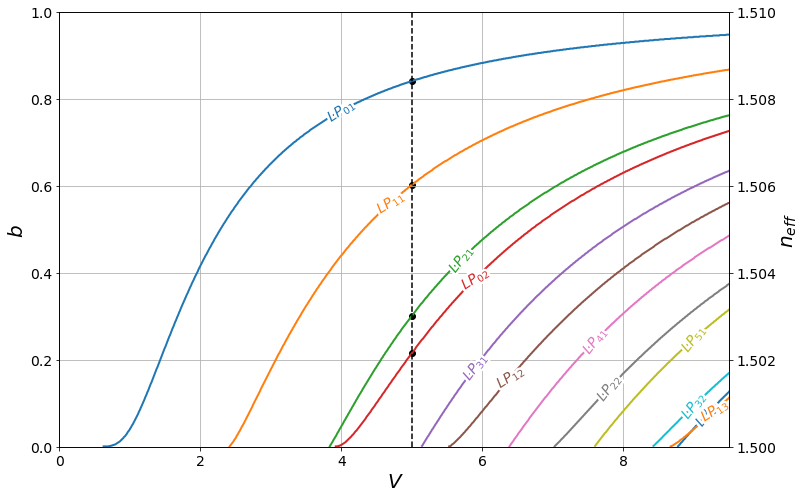

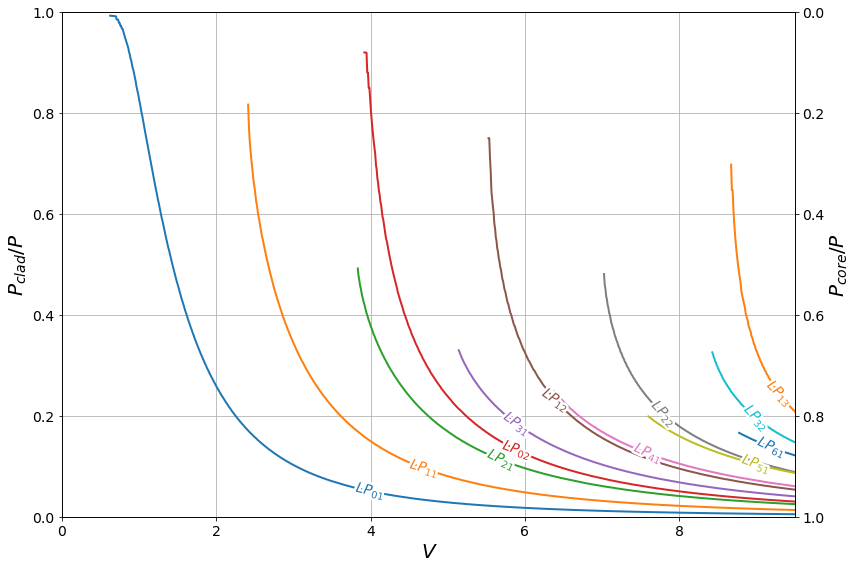

In [57]:
modes = [ ['LP',0,1], ['LP',1,1], ['LP',2,1], ['LP',0,2], ['LP',3,1], ['LP',1,2],['LP',4,1],['LP',2,2],
          ['LP',5,1], ['LP',3,2], ['LP',6,1], ['LP',1,3] ]

b = np.zeros(len(V))
neff = np.zeros(len(V))

u = np.zeros(len(V))
v = np.zeros(len(V))

p_core = np.zeros(len(V))
p_cladding = np.zeros(len(V))

prop = []
p = 0

fig1, ax1 = plt.subplots(figsize = (12, 8))
fig2, ax2 = plt.subplots(figsize = (12, 8))

for i in range(len(modes)):
    
    for j in range(len(V)):
        neff[j] = propagation(modes[i], λ[j], np.linspace(n_cl*1.0000001, n_co*0.9999999, len(V)))
        u[j] = (2*pi*a/λ[j])*np.sqrt(n_co**2 - neff[j]**2) 
        v[j] = np.sqrt(V[j]**2 - u[j]**2)
    
    m = modes[i][1]
    b = (neff**2 - n_cl**2) / (n_co**2 - n_cl**2)
    p_cladding = (u/V)**2 *(1 - kv(m,v)**2 / ( kv(m-1,v)*kv(m+1,v) ) )
    p_core = 1 - p_cladding
    
    Vc = V[np.min(np.where(~np.isnan(b)))]
    
    ax1.plot(V, b, lw = 2, label = '$'+ modes[i][0] + '_{' + str(modes[i][1]) + str(modes[i][2]) +'} $'  )
    ax2.plot(V, p_cladding, lw = 2, label = '$'+ modes[i][0] + '_{' + str(modes[i][1]) + str(modes[i][2]) +'} $'  )
    
    if(~np.isnan(neff[K])):
        prop.append([modes[i][0], modes[i][1], modes[i][2], neff[K][0], Vc])
        ax1.scatter(V[K], b[K], color = 'k')
        p += 1
        
# Propagated modes
labelLines(ax1.get_lines(), xvals = [4, 4.7, 5.7, 5.9, 5.9, 6.4, 7.6, 7.8, 9, 9, 9.2, 9.3, 9], fontsize = 14 )
ax1.axvline(V[K], ls = '--', color = 'k')
ax1.set_ylim(0, 1)
ax1.set_xlim(0, max(V))
ax1.set_xlabel(r"V", fontsize = 20, fontstyle = 'italic')
ax1.set_ylabel(r"b", fontsize = 20, fontstyle = 'italic')
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.grid()

ax0 = ax1.twinx()
ax0.set_ylim(n_cl, n_co)
ax0.set_ylabel(r'$n_{eff}$', fontsize = 20, fontstyle = 'italic')
ax0.tick_params(axis='y', labelsize=14)

plt.tight_layout()

# Power
labelLines(ax2.get_lines(), xvals = [4, 4.7, 5.7, 5.9, 5.9, 6.4, 7.6, 7.8, 9, 9, 9.2, 9.3, 9], fontsize = 14 )
ax2.set_ylim(0, 1)
ax2.set_xlim(0, max(V))
ax2.set_xlabel(r"V", fontsize = 20, fontstyle = 'italic')
ax2.set_ylabel(r"$P_{clad}/P$", fontsize = 20, fontstyle = 'italic')
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.grid()

ax0 = ax2.twinx()
ax0.set_ylim(1, 0)
ax0.set_ylabel(r'$P_{core}/P$', fontsize = 20, fontstyle = 'italic')
ax0.tick_params(axis='y', labelsize=14)

plt.tight_layout()